In [19]:
import tqdm
import time

import numpy as np
import pandas as pd
from scipy.stats import zscore

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import rbf_kernel, linear_kernel
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from imblearn.datasets import fetch_datasets
from imblearn.datasets import make_imbalance
import matplotlib.pyplot as plt

fetch_datasets = fetch_datasets(data_home="./data", verbose=1)
OZONE_DS = fetch_datasets['ozone_level']
MAMMOGRAPHY_DS = fetch_datasets['mammography']
WINE_DS = fetch_datasets['wine_quality']

In [2]:
def nystrom_spectral_decomposition(X, Z, kernel_fn, gamma, r):
    C = kernel_fn(X, Z, np.power(gamma, -2))
    W = kernel_fn(Z, Z, np.power(gamma, -2))

    Q, R = np.linalg.qr(C)
    B = R@np.linalg.pinv(W)@R.T
    B_eig_val, B_eig_vec = np.linalg.eig(B)
    idx = B_eig_val.argsort()[::-1]
    B_eig_val = B_eig_val[idx]
    B_eig_vec = B_eig_vec[:, idx]

    return np.diag(B_eig_val[:r]), Q@B_eig_vec[:, :r]


class DISCLandmarkSelection:
    def __init__(self,
                 #  kernel_fn: callable,
                 num_landmarks: int,
                 mixing_coef: float,
                 compression_ratio: float,
                 random_state: int = None):
        # self.kernel_fn = kernel_fn
        self.num_landmarks = num_landmarks  # m
        self.mixing_coef = mixing_coef  # ω
        self.compression_ratio = compression_ratio  # γ
        self.kmeans: KMeans = None
        self.K: np.ndarray = None
        self.rng = np.random.default_rng(seed=random_state)

    def fit(self, X: np.ndarray, y: np.ndarray):
        self.X = X
        self.y = y
        self.n = X.shape[0]
        self.m_0 = int(np.floor(self.num_landmarks/2))
        self.m_1 = int(np.ceil(self.num_landmarks/2))
        self.Z_0_idx = self.rng.choice(X.shape[0], self.m_0, replace=False)
        self.X_remaining_idx = np.array(
            list(set(np.arange(X.shape[0]))-set(self.Z_0_idx)))
        self.scores = self._importance_scores(
            X[self.X_remaining_idx], X[self.Z_0_idx])

        self.num_compressed_data = int(np.floor(self.compression_ratio*self.n))
        self.compressed_data = self.rng.choice(
            a=X[self.X_remaining_idx], size=self.num_compressed_data, p=self.scores.reshape(-1))
        self.kmeans = KMeans(n_clusters=self.m_1).fit(self.compressed_data)

        self.Z = np.array([tuple(x) for x in X[self.Z_0_idx]]+[tuple(c)
                          for c in self.kmeans.cluster_centers_])

    def _calculate_kernel_bandwidth(self, X: np.ndarray) -> float:  # σ
        M = np.dot(X, X.T)
        te = np.square(X).sum(axis=1)
        tr = te
        dists = -2*M + tr.reshape(1, -1) + te.reshape(1, -1).T
        return np.sqrt(1/(self.n**2-self.n)*dists.sum())

    def _calculate_distance(self, X: np.ndarray, Z_0: np.ndarray) -> np.ndarray:
        M = np.dot(X, Z_0.T)
        te = np.square(X).sum(axis=1)
        tr = np.square(Z_0).sum(axis=1)

        sum_of_squares = -2*M + tr.reshape(1, -1) + te.reshape(1, -1).T
        sum_of_squares = np.where(sum_of_squares < 0, 0, sum_of_squares)
        dists = np.sqrt(sum_of_squares)
        return dists

    def _relative_importance(self, X, Z_0) -> np.ndarray:  # ρ
        self.sigma = self._calculate_kernel_bandwidth(X)
        dist = self._calculate_distance(X, Z_0).min(axis=1)
        return dist/self.sigma

    def _importance_scores(self, X, Z_0) -> np.ndarray:  # p
        rel_importance = self._relative_importance(X, Z_0)
        score = self.mixing_coef * \
            (rel_importance/rel_importance.sum()) + \
            (1-self.mixing_coef)*(1/(self.n-self.m_0))
        return score

    def kernel_recostruction_error(self, r):
        if self.K is None:
            self.K = rbf_kernel(self.X, gamma=np.power(self.sigma, -2))

        lambda_, U = nystrom_spectral_decomposition(
            self.X, self.Z, rbf_kernel, self.sigma, r)

        reconstruction_error = np.linalg.norm(
            self.K-(U@lambda_@U.T))/np.linalg.norm(self.K)
        return reconstruction_error

    def plot(self):
        fig = plt.figure(figsize=(20, 12))
        ax = fig.add_subplot(2, 3, 1)
        ax.set_title('original data')
        ax.scatter(x=self.X[:, 0], y=self.X[:, 1],
                   edgecolors='white', linewidths=0.3)

        ax = fig.add_subplot(2, 3, 2)
        ax.set_title('initial landmarks')
        ax.scatter(x=self.X[:, 0], y=self.X[:, 1],
                   edgecolors='white', linewidths=0.3)
        ax.scatter(x=self.X[self.Z_0_idx, 0], y=self.X[self.Z_0_idx,
                   1], s=100, c='r', marker='x', linewidths=3)

        ax = fig.add_subplot(2, 3, 3)
        ax.set_title('importance score')
        ax.scatter(x=self.X[self.X_remaining_idx, 0], y=self.X[self.X_remaining_idx, 1],
                   cmap='viridis', c=self.scores, edgecolors='white', linewidths=0.3)

        ax = fig.add_subplot(2, 3, 4)
        ax.set_title('coreset and final centroids')
        ax.scatter(x=self.compressed_data[:, 0], y=self.compressed_data[:, 1],
                   edgecolors='white', linewidths=0.3)
        ax.scatter(x=self.kmeans.cluster_centers_[:, 0], y=self.kmeans.cluster_centers_[:, 1],
                   s=100, c='r', marker='o', linewidths=3)

        ax = fig.add_subplot(2, 3, 5)
        ax.set_title('DISC final landmarks')
        ax.scatter(x=self.X[:, 0], y=self.X[:, 1],
                   edgecolors='white', linewidths=0.3)
        ax.scatter(x=self.kmeans.cluster_centers_[:, 0], y=self.kmeans.cluster_centers_[:, 1],
                   s=100, c='r', marker='o', linewidths=3)
        ax.scatter(x=self.X[self.Z_0_idx, 0], y=self.X[self.Z_0_idx, 1],
                   s=100, c='r', marker='x', linewidths=3)


In [31]:
def plot_box(X, y, num_landmarks, r, mixin_coef, n_times: int = 50):
    fig = plt.figure(figsize=(10, 12))
    for i, m in enumerate(num_landmarks):
        errors_1 = np.zeros(n_times)
        disc = DISCLandmarkSelection(
            num_landmarks=m, mixing_coef=mixin_coef, compression_ratio=0.1)
        for j in tqdm.trange(n_times):
            disc.fit(X, y)
            errors_1[j] = disc.kernel_recostruction_error(r)

        errors_2 = np.zeros(n_times)
        disc = DISCLandmarkSelection(
            num_landmarks=m, mixing_coef=mixin_coef, compression_ratio=0.01)
        for j in tqdm.trange(n_times):
            disc.fit(X, y)
            errors_2[j] = disc.kernel_recostruction_error(r)

        ax = fig.add_subplot(2, 1, i+1)
        ax.set_title(f'm = {m}')
        bp = ax.boxplot([errors_1, errors_2],
                        patch_artist=True,
                        notch=False, vert=False)
        for median in bp['medians']:
            median.set(color='red',
                       linewidth=1)
        # x-axis labels
        ax.set_yticklabels([f'DISC m={m} γ=0.1', f'DISC m={m} γ=0.01'])


def plot_classification_box(X, y, num_landmarks, r, mixin_coef, n_times: int = 50):
    fig = plt.figure(figsize=(10, 12))
    for i, m in enumerate(num_landmarks):
        disc = DISCLandmarkSelection(
            num_landmarks=m, mixing_coef=mixin_coef, compression_ratio=0.1)
        scores_1 = np.zeros(n_times)
        for j in tqdm.trange(n_times):
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2)
            disc.fit(X_train, y_train)
            lambda_, U = nystrom_spectral_decomposition(
                X_train, disc.Z, rbf_kernel, disc.sigma, r)
            clf = LogisticRegression(class_weight='balanced')
            clf.fit((U@lambda_).real, y_train)

            lambda_, U = nystrom_spectral_decomposition(
                X_test, disc.Z, rbf_kernel, disc.sigma, r)
            scores_1[j] = recall_score(y_test, clf.predict((U@lambda_).real))

        scores_2 = np.zeros(n_times)
        disc = DISCLandmarkSelection(
            num_landmarks=m, mixing_coef=mixin_coef, compression_ratio=0.01)
        for j in tqdm.trange(n_times):
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2)
            disc.fit(X_train, y_train)
            lambda_, U = nystrom_spectral_decomposition(
                X_train, disc.Z, rbf_kernel, disc.sigma, r)
            labels, counts = np.unique(y, return_counts=True)
            clf = LogisticRegression(
                class_weight={l: 1/c for l, c in zip(labels, counts)})
            clf.fit((U@lambda_).real, y_train)

            lambda_, U = nystrom_spectral_decomposition(
                X_test, disc.Z, rbf_kernel, disc.sigma, r)
            scores_2[j] = recall_score(y_test, clf.predict((U@lambda_).real))

        ax = fig.add_subplot(2, 1, i+1)
        ax.set_title(f'm = {m}')
        bp = ax.boxplot([scores_1, scores_2],
                        patch_artist=True,
                        notch=False, vert=False)
        for median in bp['medians']:
            median.set(color='red',
                       linewidth=1)
        # x-axis labels
        ax.set_yticklabels([f'DISC m={m} γ=0.1', f'DISC m={m} γ=0.01'])




In [22]:
def running_time(X, y, num_landmarks, mixing_coef, compression_ratio, n_times: int = 50):
    start = time.time()

    for _ in range(n_times):
        disc = DISCLandmarkSelection(num_landmarks, mixing_coef, compression_ratio)
        disc.fit(X,y)

    end = time.time()
    return (end-start)/n_times


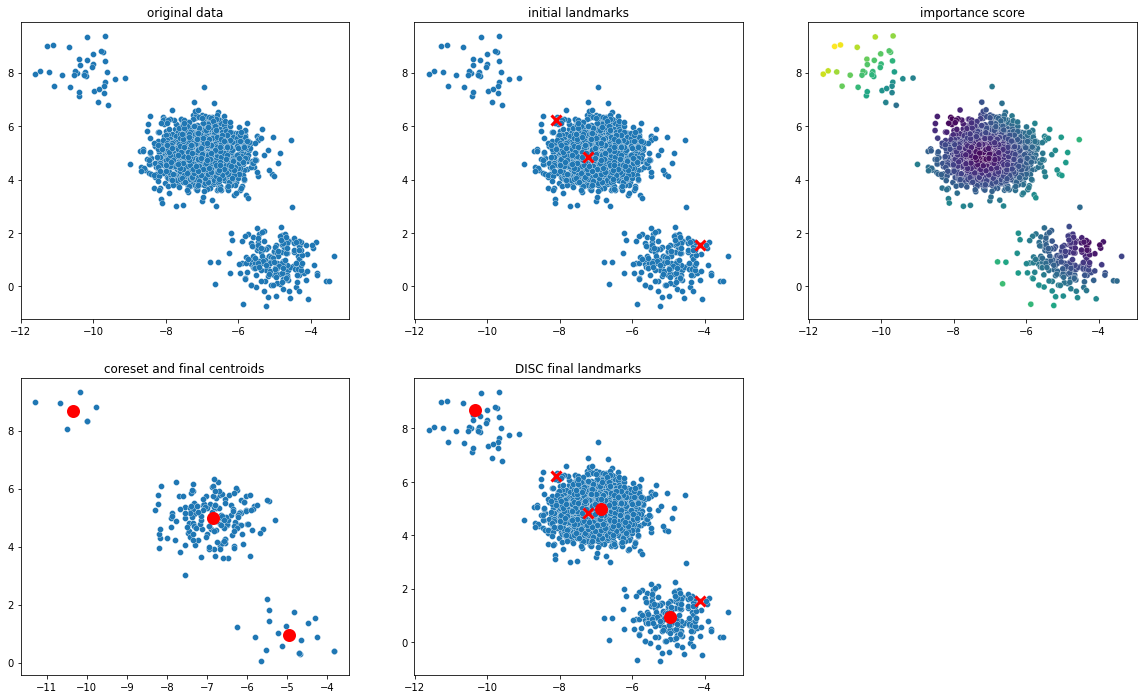

In [4]:
dataset = make_blobs(n_samples=[int(2000*0.02), int(2000*0.88), int(2000*0.1)], n_features=2, cluster_std=0.6,
                     centers=[[-10, 8], [-7, 5], [-5, 1]], random_state=2)

disc = DISCLandmarkSelection(num_landmarks=6, mixing_coef=0.5, compression_ratio=0.1, random_state=1)
disc.fit(dataset[0], dataset[1])
disc.plot()

# Experiments

## Ozone

In [10]:
X_ozone, y_ozone = OZONE_DS['data'], OZONE_DS['target']
X_ozone = zscore(X_ozone, axis=0)
# X_ozone = StandardScaler().fit_transform(X_ozone)

### reconstruction error

100%|██████████| 50/50 [00:06<00:00,  8.09it/s]


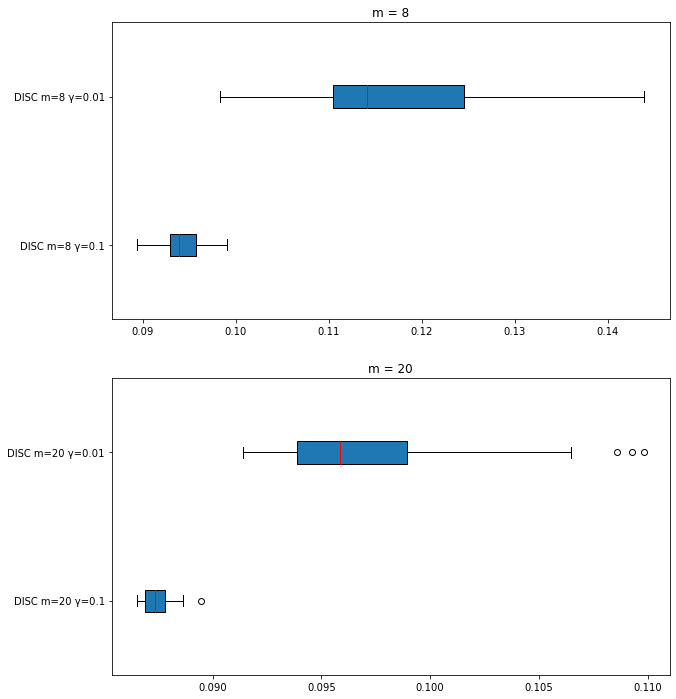

In [6]:
plot_box(X_ozone,y_ozone, [8,20], 4, 0.5, 50)

### recall score

100%|██████████| 50/50 [00:04<00:00, 11.98it/s]


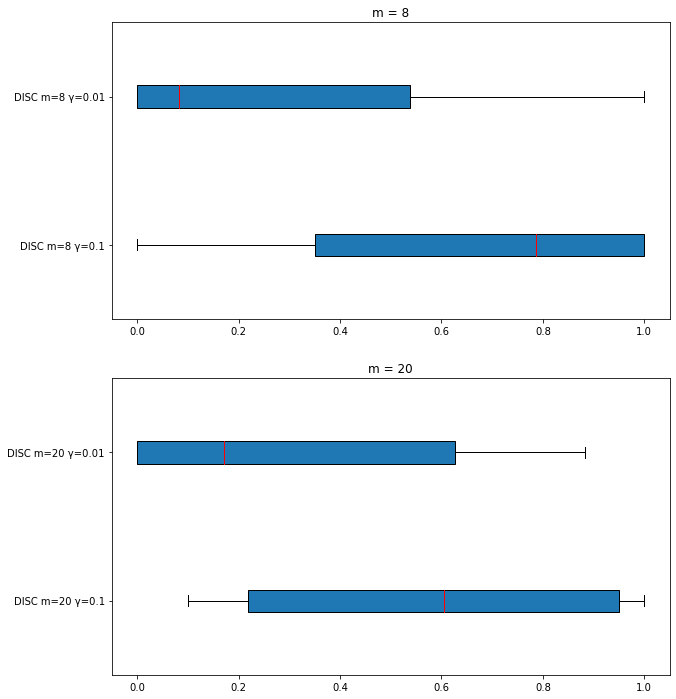

In [11]:
plot_classification_box(X_ozone,y_ozone, [8,20], 4, 0.5, 50)

## mammography

In [12]:
X_mammography, y_mammography = MAMMOGRAPHY_DS['data'], MAMMOGRAPHY_DS['target']
# X_mammography = zscore(X_mammography, axis=0)
X_mammography = StandardScaler().fit_transform(X_mammography)

### reconstruction error

100%|██████████| 50/50 [01:35<00:00,  1.92s/it]


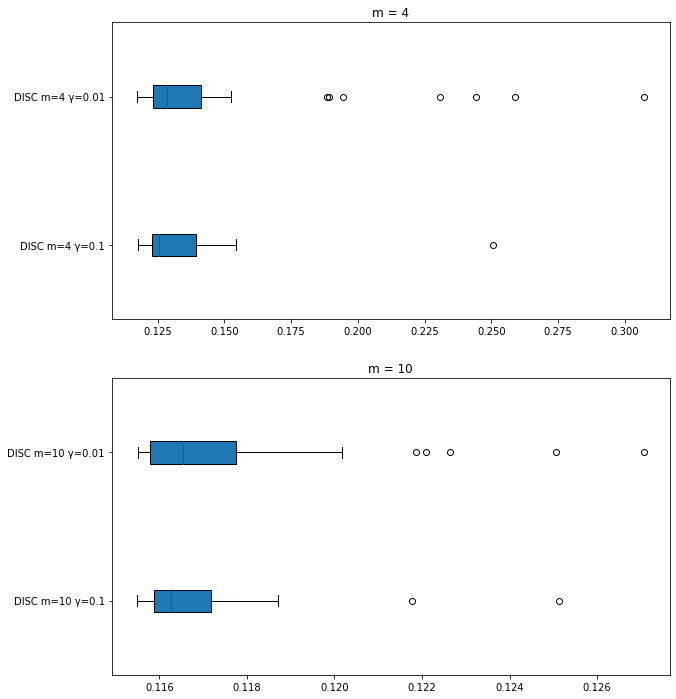

In [13]:
plot_box(X_mammography,y_mammography, [4,10], 2, 0.5, 50)

### recall score

100%|██████████| 50/50 [00:38<00:00,  1.30it/s]


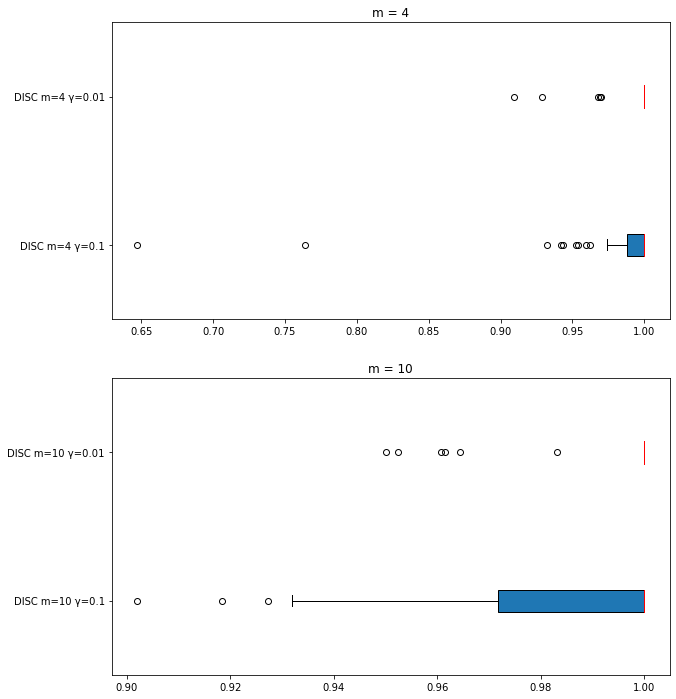

In [14]:
plot_classification_box(X_mammography,y_mammography, [4,10], 2, 0.5, 50)

## wine

In [15]:
X_wine, y_wine = WINE_DS['data'], WINE_DS['target']
# X_wine = zscore(X_wine, axis=0)
X_wine = StandardScaler().fit_transform(X_wine)

### reconstruction error

100%|██████████| 50/50 [00:18<00:00,  2.70it/s]


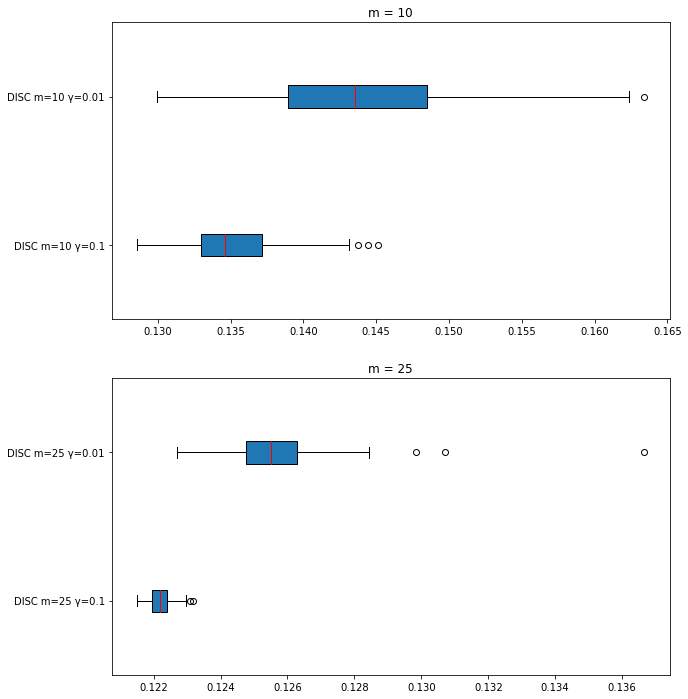

In [16]:
plot_box(X_wine,y_wine, [10,25], 5, 0.5, 50)

### recall score

100%|██████████| 50/50 [00:11<00:00,  4.50it/s]


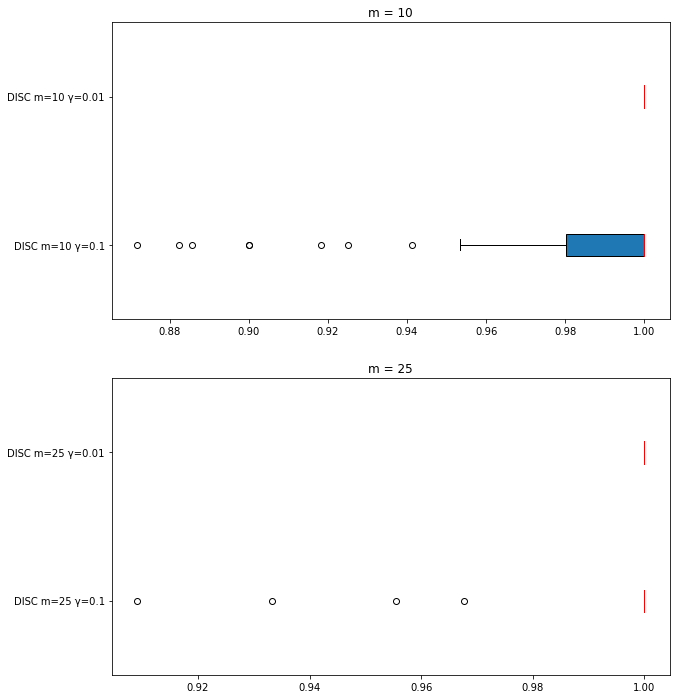

In [17]:
plot_classification_box(X_wine,y_wine, [10,25], 5, 0.5, 50)

# Running Time

## ozone

In [25]:
print(
    f'ozone m = 8 γ = 0.01: {running_time(X_ozone, y_ozone, 8, 0.5, 0.01, 50)}')
print(
    f'ozone m = 8 γ = 0.1: {running_time(X_ozone, y_ozone, 8, 0.5, 0.1, 50)}')
print("-"*50)
print(
    f'ozone m = 20 γ = 0.01: {running_time(X_ozone, y_ozone,20, 0.5, 0.01, 50)}')
print(
    f'ozone m = 20 γ = 0.1: {running_time(X_ozone, y_ozone, 20, 0.5, 0.1, 50)}')


ozone m = 8 γ = 0.01: 0.07829281806945801
ozone m = 8 γ = 0.1: 0.08607077598571777
--------------------
ozone m = 20 γ = 0.01: 0.09673640251159668
ozone m = 20 γ = 0.1: 0.1109995937347412


## mammography

In [27]:
print(
    f'mammography m = 4 γ = 0.01: {running_time(X_mammography, y_mammography, 4, 0.5, 0.01, 50)}')
print(
    f'mammography m = 4 γ = 0.1: {running_time(X_mammography, y_mammography, 4, 0.5, 0.1, 50)}')
print("-"*50)
print(
    f'mammography m = 10 γ = 0.01: {running_time(X_mammography, y_mammography,10, 0.5, 0.01, 50)}')
print(
    f'mammography m = 10 γ = 0.1: {running_time(X_mammography, y_mammography, 10, 0.5, 0.1, 50)}')


mammography m = 4 γ = 0.01: 0.9988592720031738
mammography m = 4 γ = 0.1: 0.9562506294250488
--------------------------------------------------
mammography m = 10 γ = 0.01: 0.9647301959991456
mammography m = 10 γ = 0.1: 0.9762884426116943


## wine

In [28]:
print(
    f'wine m = 10 γ = 0.01: {running_time(X_wine, y_wine, 10, 0.5, 0.01, 50)}')
print(
    f'wine m = 10 γ = 0.1: {running_time(X_wine, y_wine, 10, 0.5, 0.1, 50)}')
print("-"*50)
print(
    f'wine m = 25 γ = 0.01: {running_time(X_wine, y_wine,25, 0.5, 0.01, 50)}')
print(
    f'wine m = 25 γ = 0.1: {running_time(X_wine, y_wine, 25, 0.5, 0.1, 50)}')


wine m = 10 γ = 0.01: 0.21544026851654052
wine m = 10 γ = 0.1: 0.22870953559875487
--------------------------------------------------
wine m = 25 γ = 0.01: 0.22943326950073242
wine m = 25 γ = 0.1: 0.2400463628768921


In [62]:
def plot_reconstruction_error_per_landmarks(X, y, mixing_coef, r, compression_ratio: list, num_landmarks: list):
    errors = np.zeros((len(num_landmarks), len(compression_ratio)))
    times = np.zeros((len(num_landmarks), len(compression_ratio)))
    
    for i, m in enumerate(num_landmarks):
        for j, cr in enumerate(compression_ratio):
            start = time.time()
            disc = DISCLandmarkSelection(m, mixing_coef, cr)
            disc.fit(X, y)
            errors[i, j] = disc.kernel_recostruction_error(r)
            end = time.time()
            times[i, j] = (end-start)

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(2,1,1)
    ax.plot([i*r for i in range(1, len(num_landmarks)+1)], errors, 'o-', label=['DISC-γ='+str(cr) for cr in compression_ratio])
    ax.legend()

    ax = fig.add_subplot(2,1,2)
    ax.loglog(times, errors, 'o-', label=['DISC-γ='+str(cr) for cr in compression_ratio])
    ax.legend()
    # return errors


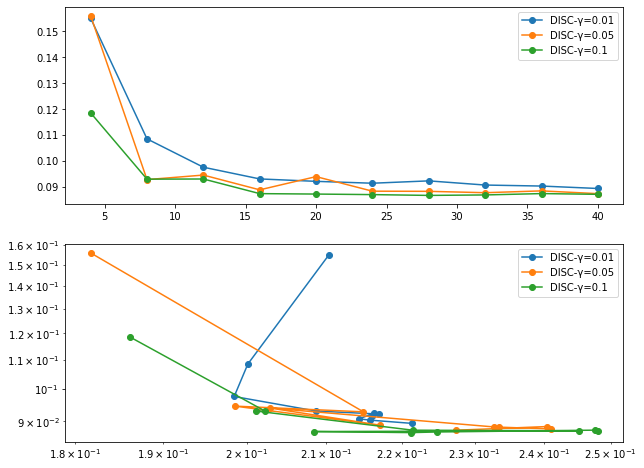

In [63]:
plot_reconstruction_error_per_landmarks(X_ozone, y_ozone, 0.5, 4, [0.01,0.05,0.1],[i*4 for i in range(1,11)])